In [3]:
import random
import torch
import collections
import re
import matplotlib.pyplot as plt


def read_time_machine():
    with open('local_poem.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]


def tokenize(lines, token='word'):
    """将文本行拆分为单词或字符标记"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知令牌类型：' + token)
        return None


class Vocab(object):
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = self.count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens

        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    def count_corpus(self, tokens):
        """统计标记的频率"""
        if len(tokens) == 0 or isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        return collections.Counter(tokens)

tokens = tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 142),
 ('a', 72),
 ('he', 60),
 ('to', 56),
 ('of', 55),
 ('and', 51),
 ('in', 30),
 ('was', 27),
 ('leo', 25),
 ('as', 25)]

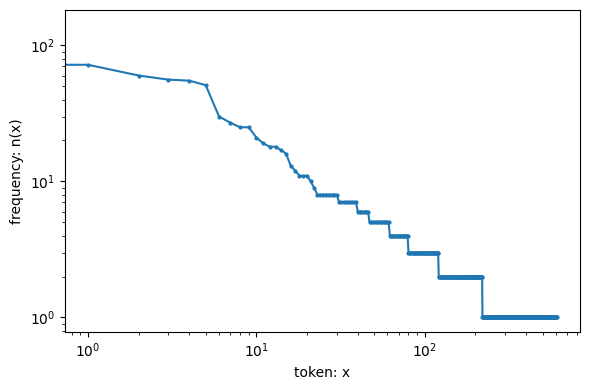

In [4]:
freqs = [freq for token, freq in vocab.token_freqs]

# 2. 使用 Matplotlib 绘制双对数图
plt.figure(figsize=(6, 4))  # 设置画布大小
# 绘制词频曲线（x 轴为 token 序号，y 轴为频率，双对数刻度）
plt.plot(freqs, marker='.', linestyle='-', markersize=4)
plt.xlabel('token: x')       # x 轴标签
plt.ylabel('frequency: n(x)')# y 轴标签
plt.xscale('log')            # x 轴设为对数刻度
plt.yscale('log')            # y 轴设为对数刻度
plt.tight_layout()           # 优化布局
plt.show()                   # 显示图像

# 这是一个基于二元的马尔可夫模型假设

In [5]:
bigram_tokens=[pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab=Vocab(bigram_tokens)
print(bigram_vocab.token_freqs[:10])

[(('of', 'the'), 21), (('in', 'the'), 15), (('the', 'grove'), 12), (('as', 'he'), 10), (('to', 'the'), 9), (('the', 'forest'), 8), (('seemed', 'to'), 8), (('the', 'guardian'), 8), (('as', 'if'), 7), (('with', 'a'), 6)]


# 这是一个基于三元的马尔可夫模型假设

In [6]:
trigram_tokens=[triple for triple in zip(corpus[:-1], corpus[1:], corpus[2:])]
trigram_vocab=Vocab(trigram_tokens)
print(trigram_vocab.token_freqs[:10])

[(('of', 'the', 'grove'), 4), (('as', 'if', 'they'), 3), (('he', 'saw', 'a'), 3), (('to', 'glow', 'with'), 3), (('of', 'the', 'forest'), 3), (('the', 'grove', 'he'), 3), (('the', 'forest', 'the'), 2), (('forest', 'the', 'mist'), 2), (('seemed', 'to', 'part'), 2), (('any', 'leo', 'had'), 2)]


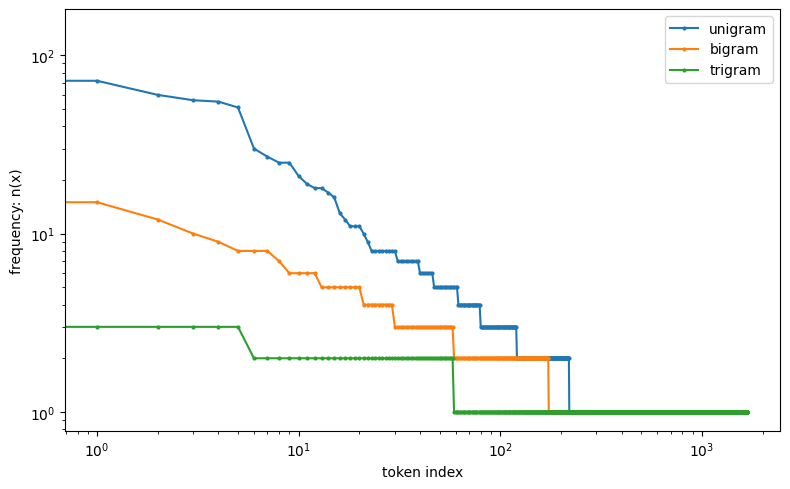

In [7]:
# 2. 构建一元组（unigram）
unigram_tokens = corpus
unigram_vocab = Vocab(unigram_tokens)
unigram_freqs = [freq for token, freq in unigram_vocab.token_freqs]

# 3. 构建二元组（bigram）
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]

# 4. 构建三元组（trigram）
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

# 5. 使用 matplotlib 绘制多组频率的双对数图
plt.figure(figsize=(8, 5))  # 设置画布大小
# 绘制一元组频率曲线
plt.plot(unigram_freqs, marker='.', linestyle='-', markersize=4, label='unigram')
# 绘制二元组频率曲线
plt.plot(bigram_freqs, marker='.', linestyle='-', markersize=4, label='bigram')
# 绘制三元组频率曲线
plt.plot(trigram_freqs, marker='.', linestyle='-', markersize=4, label='trigram')

plt.xlabel('token index')       # x 轴标签，对应 token 序号
plt.ylabel('frequency: n(x)')  # y 轴标签，对应频率
plt.xscale('log')               # x 轴设为对数刻度
plt.yscale('log')               # y 轴设为对数刻度
plt.legend()                    # 显示图例
plt.tight_layout()              # 优化布局
plt.show()                      # 显示图像